# Imports and setup 

In [1]:
from langgraph.graph import StateGraph, END, START
from typing import TypedDict, Annotated, List, Dict, TypedDict, Any
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from langchain_community.utilities.duckduckgo_search import DuckDuckGoSearchAPIWrapper
from langchain.pydantic_v1 import BaseModel, Field
from langchain_community.tools.tavily_search import TavilySearchResults
from tavily import TavilyClient
from langchain_core.prompts import(
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
    MessagesPlaceholder
)
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
import functools
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from IPython.display import Image, display
from datetime import datetime
import traceback
import json
import os 

C:\Users\Kit\PycharmProjects\SEO_AI\.venv\Lib\site-packages\IPython\core\interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
os.environ["OPENAI_API_KEY"] = ""
os.environ["ANTHROPIC_API_KEY"] = ""
os.environ["TAVILY_API_KEY"] = ""

# Initialising models 

In [3]:
gpt4o_model = ChatOpenAI(model="gpt-4o-mini", temperature=0.35)
claude_haiku = ChatAnthropic(model="claude-3-5-sonnet-20240620", temprature = 0.65)

C:\Users\Kit\PycharmProjects\SEO_AI\.venv\Lib\site-packages\IPython\core\interactiveshell.py:3517: UserWarning: WARNING! temprature is not default parameter.
                temprature was transferred to model_kwargs.
                Please confirm that temprature is what you intended.
  if await self.run_code(code, result, async_=asy):


# Initialising the agent state

In [4]:
class AgentState(TypedDict):
    topic: str  # user input
    
    stats: Any # actual tavily search result
    relevant_data_stats: Any # yes/no
    stats_review: Any # Why data isnt enough or relevant feedback 
    
    quotes: Any # 1. generated queries 2. actual returned search data
    relevant_data_quotes: Any # yes/no
    quotes_review: Any # Why data isnt enough or relevant feedback 
    
    topic_search: Any # 1. generated queries 2. actual returned search data
    relevant_data_topicsearch: Any # yes/no
    topic_search_review: Any # Why data isnt enough or relevant feedback 

    writer: Any #place holder
    
    sender: Any
    messages: Annotated[list, operator.add]

# Setting tools 
## Grading function

In [5]:
class Gradequestion(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


system = """You are a grader assessing if there is enough relevant data related to the task provided. \n 
    It does not need to be a stringent test. The goal is to ensure that there is useful data so that we can later generate an article. \n
    If the user data provides enough information to help you output draft an article, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Data : {data}"),
    ]
)

structured_llm_grader = gpt4o_model.with_structured_output(Gradequestion)


query_grader = grade_prompt | structured_llm_grader


# Decide to continue functions 
def decide_to_continue_topic(state):
    """
    Determines whether to generate an answer, or ask an additional question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    enough_context = state["relevant_data_topicsearch"]
    print(enough_context)
        
    if enough_context == []:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: QUERY DOES NOT PROVIDE ENOUGH CONTEXT ---"
        )
        return "review_node_topic"
    else:
        # We have relevant context, so continue to gather user requirements
        print("---DECISION: GATHER REQUIREMENTS---")
        return "draft_article_node"


def decide_to_continue_stats(state):
    """
    Determines whether to generate an answer, or ask an additional question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    enough_context = state["relevant_data_stats"]
    print(enough_context)
        
    if enough_context == []:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: QUERY DOES NOT PROVIDE ENOUGH CONTEXT ---"
        )
        return "review_node_stats"
    else:
        # We have relevant context, so continue to gather user requirements
        print("---DECISION: GATHER REQUIREMENTS---")
        return "draft_article_node"



def decide_to_continue_quotes(state):
    """
    Determines whether to generate an answer, or ask an additional question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    enough_context = state["relevant_data_quotes"]
    print(enough_context)
        
    if enough_context == []:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: QUERY DOES NOT PROVIDE ENOUGH CONTEXT ---"
        )
        return "review_node_quotes"
    else:
        # We have relevant context, so continue to gather user requirements
        print("---DECISION: GATHER REQUIREMENTS---")
        return "draft_article_node"







# Desicion nodes
def descision_node_topic(state):
    """
    Determines whether the data provided is relevant to the topic and task.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK QUERY ENOUGH TO ANSWER QUESTION--")
    data = state["topic_search"]

    enough_context = []

    score = query_grader.invoke(
        {"data": data}
    )
    grade = score.binary_score
    if grade == "yes":
        print("---GRADE: QUESTION RELEVANT---")
        enough_context.append(grade)
    else:
        print("---GRADE: QUESTION NOT RELEVANT---")
    print(f"THIS WAS THE GRADE {grade}")
    return {"relevant_data_topicsearch": enough_context}



def descision_node_stats(state):
    """
    Determines whether the data provided is relevant to the topic and task.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK QUERY ENOUGH TO ANSWER QUESTION--")
    data = state["stats"]

    enough_context = []

    score = query_grader.invoke(
        {"data": data}
    )
    grade = score.binary_score
    if grade == "yes":
        print("---GRADE: QUESTION RELEVANT---")
        enough_context.append(grade)
    else:
        print("---GRADE: QUESTION NOT RELEVANT---")
    print(f"THIS WAS THE GRADE {grade}")
    return {"relevant_data_stats": enough_context}



def descision_node_quotes(state):
    """
    Determines whether the data provided is relevant to the topic and task.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK QUERY ENOUGH TO ANSWER QUESTION--")
    data = state["quotes"]

    enough_context = []

    score = query_grader.invoke(
        {"data": data}
    )
    grade = score.binary_score
    if grade == "yes":
        print("---GRADE: QUESTION RELEVANT---")
        enough_context.append(grade)
    else:
        print("---GRADE: QUESTION NOT RELEVANT---")
    print(f"THIS WAS THE GRADE {grade}")
    return {"relevant_data_quotes": enough_context}

# Setting tools
## Search tools 

In [6]:
class Queries(BaseModel):
    queries: List[str]

search_engine = DuckDuckGoSearchAPIWrapper()


@tool
def search_engine_topic(topic_search: Queries):
    """Search engine to the internet."""

    aggregate_search = []

    for q in topic_search.queries:
    
        print(f"Query: {q}")
        results = DuckDuckGoSearchAPIWrapper()._ddgs_text(q)
        aggregate_search.append(results)
    
    return {"topic_search": aggregate_search}

@tool
def search_engine_quotes(quotes: Queries):
    """Search engine to the internet."""
    aggregate_search = []

    for q in quotes.queries:
    
        print(f"Query: {q}")
        results = DuckDuckGoSearchAPIWrapper()._ddgs_text(q)
        aggregate_search.append(results)
    return {"quotes": aggregate_search}


# Agentic QA
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

# Setting Nodes
## Review Nodes

In [7]:
def review_node_topic():
    messages = gpt4o_model.with_structured_output(Queries).invoke([
        SystemMessage(content="You are an expert researcher. Your task is to review the research collected on the topic provided and answer why the data included is not enough or not relevant to our topic. You must first read the data collected, Then output your thoughts on how it could be improved in terms of what else should be collected."),
        HumanMessage(content=f"Topic: {state['topic']}")
    ])
    return {"topic_search_review": messages.content}

def review_node_stats():
    messages = gpt4o_model.with_structured_output(Queries).invoke([
        SystemMessage(content="You are an expert researcher.Your task is to review the research collected on the statistics about the topic we are researching. You must provide an answer to why the data included is not enough or not relevant to our task of getting quotes about the topic. You must first read the data collected, Then output your thoughts on how it could be improved in terms of what else should be collected."),
        HumanMessage(content=f"Topic: {state['topic']}, Topic specific task: Stats data, data colletected: {state["stats"]}")
    ])
    return {"stats_review": messages.content}

def review_node_quotes():
    messages = gpt4o_model.with_structured_output(Queries).invoke([
        SystemMessage(content="You are an expert researcher. Your task is to review the research collected on the quotes about the topic we are researching. You must provide an answer to why the data included is not enough or not relevant to our task of getting quotes about the topic. You must first read the data collected, Then output your thoughts on how it could be improved in terms of what else should be collected."),
        HumanMessage(content=f"Topic: {state['topic']}, Topic specific task: quotes data, data collected: {state["quotes"]}")
    ])
    return {"quotes_review": messages.content}
    

# Setting nodes
## Main search Nodes

In [8]:
# This is okay could be improved. 
def researchq_topic_node(state: AgentState):
    queries = gpt4o_model.with_structured_output(Queries).invoke([
        SystemMessage(content="You are an expert researcher. Your task is to collect general research on the topic provided, this could be about the market, general industry trends ect. You will output a search query based on the relevant topic to collect this data. Please only output 2 queries"),
        HumanMessage(content=f"Topic: {state['topic']}, feedback on previous collected data: {state["topic_search_review"]}")
    ])
    return {"topic_search": queries}


# This is good and returning relevant information. This is not a researchq because it is actually returning the data within it. 
def research_stats_node(state: AgentState):
    queries = gpt4o_model.with_structured_output(Queries).invoke([
        SystemMessage(content="You are an expert researcher. Your task is to collect statistics and other data on the topic provided. You will do this by generating a search query based on the topic the user has provided"),
        HumanMessage(content=f"Topic: {state['topic']}, feedback on previous collected data: {state["stats_review"]}")
    ])
    content = state['stats'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r)
    return {"stats": content}



def researchq_quotes_node(state: AgentState):
    queries = gpt4o_model.with_structured_output(Queries).invoke([
        SystemMessage(content="We are creating an article based on a certain topic. In order for us to do this we need to find quotes on this topic. You will be given the topic. Your task is to output a search query to find quotes based on that topic. This is so that we can find relevant data. Please only output 2 queries"),
        HumanMessage(content=f"Topic: {state['topic']}, feedback on previous collected data: {state["quotes_review"]}")
    ])

    print(f"Try this?: {queries}")
    return {"quotes": queries}


In [9]:
# Continued workflow

In [10]:
def draft_article_node(state: AgentState):
    messages = gpt4o_model.invoke([
        SystemMessage(content="please draft a short article using the data provide about the topic."),
        HumanMessage(content=f"Topic: {state['topic']}, collected data: {state["topic_search"]}")
    ])
    return {"writer": messages.content}

In [11]:
workflow = StateGraph(AgentState)

In [12]:

# Query generating nodes (stats currently returns search results)
workflow.add_node(researchq_topic_node, "researchq_topic_node")
workflow.add_node(research_stats_node, "research_stats_node")
workflow.add_node(researchq_quotes_node, "researchq_quotes_node")

# Tool nodes to search for results
workflow.add_node(search_engine_topic, "search_engine_topic")
workflow.add_node(search_engine_quotes, "search_engine_quotes")

# Asses weather data is relevant nodes
workflow.add_node(descision_node_topic, "descision_node_topic")
workflow.add_node(descision_node_stats, "descision_node_stats")
workflow.add_node(descision_node_quotes, "descision_node_quotes")

# Decide weather to continue or not nodes (actually a function)

# Review nodes 
workflow.add_node(review_node_topic, "review_node_topic")
workflow.add_node(review_node_stats, "review_node_stats")
workflow.add_node(review_node_quotes, "review_node_quotes")

# Repeate! 

# or

# collected data nodes 
workflow.add_node(draft_article_node, "draft_article_node")


In [13]:
# Generate query 
workflow.add_edge(START, "researchq_topic_node")
workflow.add_edge(START, "research_stats_node")
workflow.add_edge(START, "researchq_quotes_node")

# query to tools 
workflow.add_edge("researchq_topic_node", "search_engine_topic")
workflow.add_edge("researchq_quotes_node", "search_engine_quotes")

# Assess weather data is relevant or not 
workflow.add_edge("search_engine_topic", "descision_node_topic")
workflow.add_edge("research_stats_node", "descision_node_stats")
workflow.add_edge("search_engine_quotes", "descision_node_quotes")


# Is the data relevant? 
workflow.add_conditional_edges(
    "descision_node_topic",
    decide_to_continue_topic ,
    {
        "review_node_topic": "review_node_topic",
        "draft_article_node": "draft_article_node",
    },
)


workflow.add_conditional_edges(
    "descision_node_stats",
    decide_to_continue_stats ,
    {
        "review_node_stats": "review_node_stats",
        "draft_article_node": "draft_article_node",
    },
)


workflow.add_conditional_edges(
    "descision_node_quotes",
    decide_to_continue_quotes ,
    {
        "review_node_quotes": "review_node_quotes",
        "draft_article_node": "draft_article_node",
    },
)


# Data is not relevant, provide feedback to the query generator
workflow.add_edge("review_node_topic", "researchq_topic_node")
workflow.add_edge("review_node_stats", "research_stats_node")
workflow.add_edge("review_node_quotes", "researchq_quotes_node")



# Data is relevant, draft article and finish 
workflow.add_edge("draft_article_node", END)


thread = {"configurable": {"thread_id": "1"}}

graph = workflow.compile()

# Visulise the Graph 

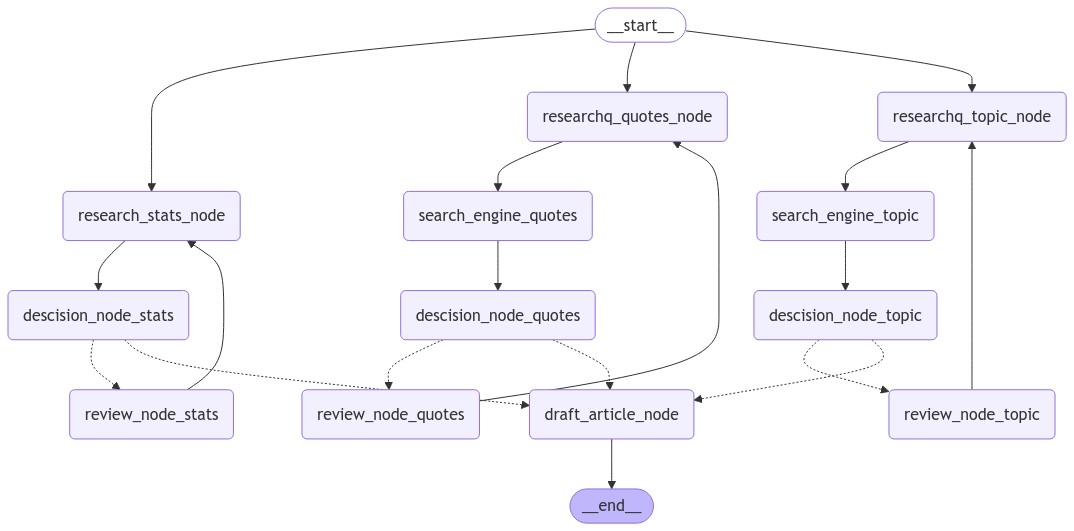

In [14]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles


display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [15]:
thread = {"configurable": {"thread_id": "2"}}

graph = workflow.compile()



all_responses = []

for s in graph.stream(
        {"topic": "Global Tech stocks",
        "stats": [],
        "quotes": [],
        "topic_search": [],
        "topic_search_review": [],
        "stats_review": [],
        "quotes_review": []}
):
    if "__end__" not in s:
        print(s)
        print("----")
        all_responses.append(s)

Try this?: queries=['quotes about global tech stocks', 'famous quotes on technology investments']
{'researchq_quotes_node': {'quotes': Queries(queries=['quotes about global tech stocks', 'famous quotes on technology investments'])}}
----
{'researchq_topic_node': {'topic_search': Queries(queries=['current trends in global tech stocks 2023', 'impact of economic factors on global tech stock performance'])}}
----
{'research_stats_node': {'stats': [{'title': '2023 stock market report | Tech propels stocks | Fidelity', 'url': 'https://www.fidelity.com/learning-center/trading-investing/markets-sectors/stock-market-report', 'content': 'Global stocks advanced nearly 22% in 2023. Big tech and artificial intelligence bolstered stocks. Stocks might go higher in 2024, but uncertainty could lead to a seesaw. ... The MSCI World Index is a market capitalization weighted index that is designed to measure the investable equity market performance for global investors of developed markets.', 'score': 0.99

In [16]:
all_responses

[{'researchq_quotes_node': {'quotes': Queries(queries=['quotes about global tech stocks', 'famous quotes on technology investments'])}},
 {'researchq_topic_node': {'topic_search': Queries(queries=['current trends in global tech stocks 2023', 'impact of economic factors on global tech stock performance'])}},
 {'research_stats_node': {'stats': [{'title': '2023 stock market report | Tech propels stocks | Fidelity',
     'url': 'https://www.fidelity.com/learning-center/trading-investing/markets-sectors/stock-market-report',
     'content': 'Global stocks advanced nearly 22% in 2023. Big tech and artificial intelligence bolstered stocks. Stocks might go higher in 2024, but uncertainty could lead to a seesaw. ... The MSCI World Index is a market capitalization weighted index that is designed to measure the investable equity market performance for global investors of developed markets.',
     'score': 0.99696034,
     'raw_content': None},
    {'title': "These 7 Tech Stocks Command Almost 90%